<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_PRAC_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 28회 ADP 복원

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import chi2_contingency, f_oneway
import numpy as np

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score , classification_report

import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import VotingClassifier

#!pip install lifelines
#!pip install pingouin
import time
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy.stats import mannwhitneyu
import pingouin as pg

# 기계학습 (50점)

## 데이터 설명
- 데이터 출처 : https://www.kaggle.com/datasets/dipam7/student-grade-prediction?resource=download 후처리
- 데이터 링크 : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv
- 데이터 설명 : 학생의 다양한 주변 환경에 따른 결석 등급 (absences)
    - sex : 성별 (F : 여성 / M :남성)
    - age : 나이
    - pstatus : 부모와 동거 유무 (T : 동거중 , A : 별거)
    - medu : 어머니 교육(0 - 없음, 1 - 초등 교육(4학년), 2 - 5~9학년, 3 - 중등 교육 또는 4 - 고등 교육)
    - fedu : 아버지 교육(0 - 없음, 1 - 초등 교육(4학년), 2 - 5 - 9학년, 3 - 중등 교육 또는 4 - 고등 교육)
    - guardian : 학생의 보호자
    - traveltime : 집에서 학교까지 이동 시간(1 - <15분, 2 - 15 - 30분, 3 - 30분 - 1시간, 또는 4 - >1시간)
    - studytime : 주간 학습 시간(1 - <2시간, 2 - 2 - 5시간, 3 - 5 - 10시간 또는 4 - >10시간)
    - failures : 과거 클래스 실패 수(n if 1<=n<3, 그렇지 않으면 4)
    - freetime : 방과 후 자유 시간(숫자: 1 - 매우 낮음에서 5 - 매우 높음)
    - famrel : 가족 관계의 질(숫자: 1 - 매우 나쁨에서 5 - 훌륭함)
    - absences : 학교 결석 횟수등급 (0~5, 높은 숫자일수록 많은 결석 횟수)

In [3]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv")
df.head()

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,F,18,A,4,4,mother,2,2,0,3,4,2
1,F,17,T,1,1,father,1,2,0,3,5,1
2,F,15,T,1,1,mother,1,2,3,3,4,3
3,F,15,T,4,2,mother,1,3,0,2,3,0
4,F,16,T,3,3,father,1,2,0,3,4,1


##### 1-1. EDA를 진행하고 (+시각화) , 차원축소의 필요성이 있는지 확인 (5점)

,sex,age,pstatus,medu,fedu,guardian,traveltime,studytime,failures,freetime,famrel,absences
0,0,0,0,0,0,0,0,0,0,0,0,0


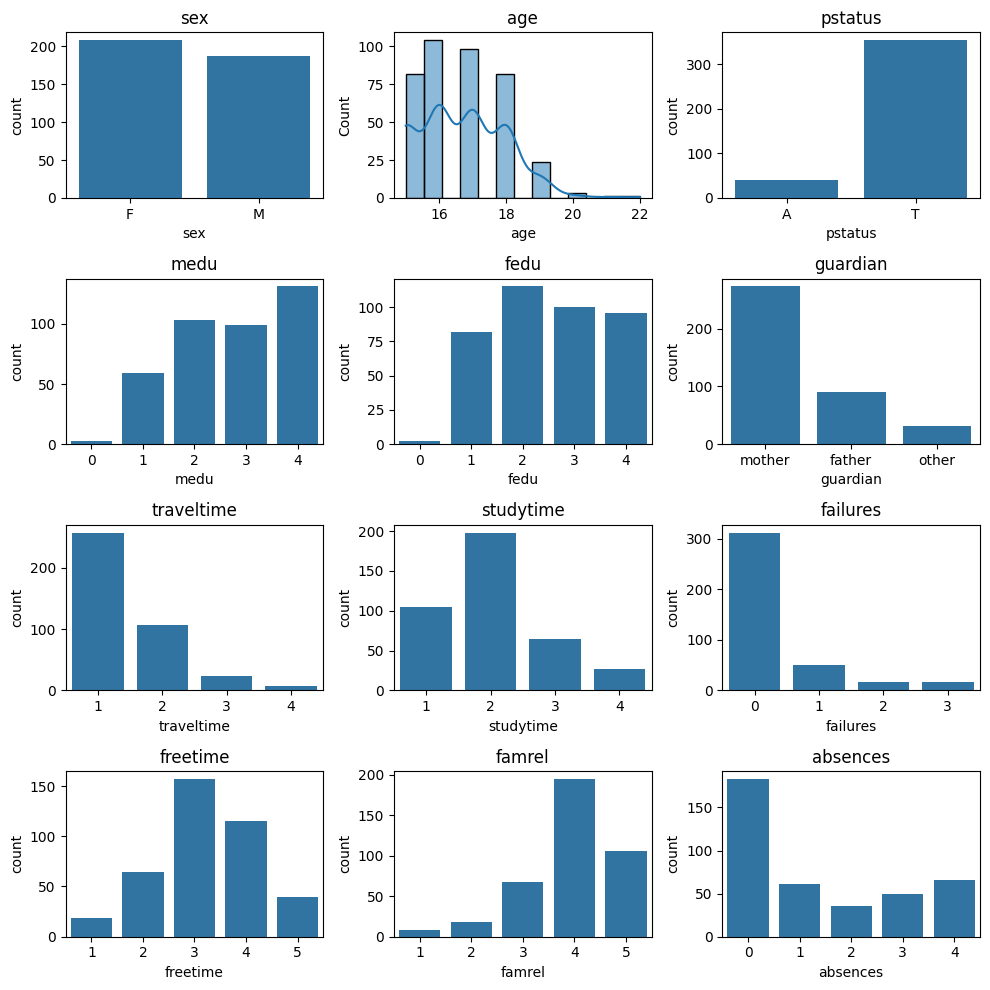

,Columns,p_value,Deicison
0,age,0.000016,유의하다
1,failures,0.005994,유의하다
2,famrel,0.840443,유의하지않다
3,fedu,0.673619,유의하지않다
4,freetime,0.483288,유의하지않다
5,guardian,0.015805,유의하다
6,medu,0.451756,유의하지않다
7,pstatus,0.019316,유의하다
8,sex,0.793048,유의하지않다
9,studytime,0.044393,유의하다


In [4]:
# 1. 결측
display(df.isna().sum().to_frame().T)

# 2. EDA
fig, axes = plt.subplots(4,3, figsize=  (10,10))
for axes, col in zip(axes.flatten() , df.columns) :
  if col != 'age' :
    sns.countplot(x = df[col], ax = axes)

  else :
    sns.histplot(x = df[col], kde = True, ax = axes)

  axes.set_title(col)
plt.tight_layout()
plt.show()

# 3. Absence별 유의한지 통계검정
res = []
for col in df.columns.difference(['absences']) :
  if col == 'age' :
    g = [group['age'] for name, group in df.groupby('absences')]
    stat, p_val = f_oneway(* g)

  else :
    tab = pd.crosstab(df[col], df['absences'])
    stat, p_val, _, _ = chi2_contingency(tab)

  res.append({
      'Columns' : col,
      'p_value' : p_val,
      'Deicison' : '유의하다' if p_val < 0.05 else '유의하지않다'
  })

display(pd.DataFrame(res))


In [5]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# 차원축소의 필요성 판단하기
# 문제) 다 명목, 순서형인데 어떻게 차원 축소를 논의하는가?
# 대안 1) One Hot Encoding + VIF
#         > Label Encoding 으로 숫자를 매핑해주면 해석의 문제가 발생한다.

# 대안 2) 명목형은 Cremer`V + 수치형끼리는 VIF

print('''
명목/순서형 변수가 포함된 데이터에서의 차원 축소 필요성 판단 절차
1. 명목형 - One Hot Encoding
2. 순서형 - 스케일링으로 VIF계산 안정화 및 분산 비교가능
으로 데이터 변환 후, 상관분석 (Pearson) 과 VIF 수행
''')

clean_df = pd.DataFrame()
for col in df.columns.difference(['absences']) :
  if df[col].dtypes != 'object' :
    clean_df[col] = StandardScaler().fit_transform(df[[col]]).flatten()

  else :
    dummies = pd.get_dummies(df[col], prefix = col, dtype =int, drop_first = True)
    for d_col in dummies.columns :
      clean_df[d_col] = dummies[d_col]

# 상관분석
cor_mat = clean_df.corr(method = 'pearson')
cor_table = cor_mat.unstack().reset_index()
display(cor_table[(cor_table['level_0'] != cor_table['level_1']) & (abs(cor_table.iloc[:,2] >= 0.3))] )

# VIF
vif = pd.DataFrame()
vif['var'] = clean_df.columns
vif['vif'] = [variance_inflation_factor(clean_df.values, i ) for i in range(clean_df.shape[1])]
display(vif)
print('''
Pearson 상관분석 결과, fedu와 medu 사이에서 0.62의 높은 상관을 보였으며,
이는 부모 학력 수준 간 정보 중복 가능성을 시사한다. 다만 대부분 변수 간 상관은 0.3 이하로 낮아,
변수 간 중복 정보는 제한적인 것으로 판단된다.

또한 VIF 분석 결과, 주요 연속형 및 순서형 변수들의 다중공선성은 VIF < 2 수준으로 매우 낮았으며,
One-Hot Encoding된 더미 변수들에서 나타나는 무한대 VIF 값은 기준 범주 제거를 통해 해결 가능하다.

이러한 분석을 종합할 때, 본 데이터에서는 제한적인 변수 통합 또는 제거는 가능하나,
전반적으로는 **차원 축소의 필요성이 크지 않음**을 확인할 수 있다.
''')


명목/순서형 변수가 포함된 데이터에서의 차원 축소 필요성 판단 절차
1. 명목형 - One Hot Encoding
2. 순서형 - 스케일링으로 VIF계산 안정화 및 분산 비교가능
으로 데이터 변환 후, 상관분석 (Pearson) 과 VIF 수행



,level_0,level_1,0
6,age,guardian_other,0.398396
43,fedu,medu,0.623455
72,guardian_other,age,0.398396
87,medu,fedu,0.623455


,var,vif
0,age,1.231963
1,failures,1.237292
2,famrel,1.037707
3,fedu,1.736346
4,freetime,1.099586
5,guardian_mother,2.949454
6,guardian_other,1.456340
7,medu,1.766852
8,pstatus_T,3.708036
9,sex_M,2.077087



Pearson 상관분석 결과, fedu와 medu 사이에서 0.62의 높은 상관을 보였으며,
이는 부모 학력 수준 간 정보 중복 가능성을 시사한다. 다만 대부분 변수 간 상관은 0.3 이하로 낮아,
변수 간 중복 정보는 제한적인 것으로 판단된다.

또한 VIF 분석 결과, 주요 연속형 및 순서형 변수들의 다중공선성은 VIF < 2 수준으로 매우 낮았으며,
One-Hot Encoding된 더미 변수들에서 나타나는 무한대 VIF 값은 기준 범주 제거를 통해 해결 가능하다.

이러한 분석을 종합할 때, 본 데이터에서는 제한적인 변수 통합 또는 제거는 가능하나,
전반적으로는 **차원 축소의 필요성이 크지 않음**을 확인할 수 있다.



#### 1-2. 데이터 품질 개선을 위한 방법이 있는지 찾고 데이터셋을 재생성하라 (5점)

In [6]:
print('''
본 데이터는 결측치 없이 전반적으로 품질이 우수하였으나,
부모 학력 정보(medu, fedu)의 중복성과, 명목형 변수의 인코딩 방식에 개선 여지가 있었다.

따라서 fedu와 medu를 parents_edu로 통합하여 다중공선성을 줄였으며,
sex, pstatus, guardian은 One-Hot Encoding으로 재처리하여 모델 오해 가능성을 제거하였다.

또한 age 변수는 표준화를 통해 분산 영향력을 조정하였으며,
최종적으로 품질이 개선된 데이터셋(df_final)을 생성하였다.
''')

df1 = df.copy()
# 1) 부모 학력 정보 처리
df1['parent_edu'] = df1['medu'] + df1['fedu'] / 2
df1 = df1.drop(columns = ['medu','fedu'], axis = 1)


df_final = pd.DataFrame()
for col in df1.columns :
  if df1[col].dtypes != 'object' and col != 'absences':
    df_final[col] = StandardScaler().fit_transform(df1[[col]]).flatten()

  elif col !=  'absences' :
    dummies = pd.get_dummies(df1[col], prefix = col, dtype =int, drop_first = True)
    for d_col in dummies.columns :
      df_final[d_col] = dummies[d_col]

  else :
    df_final[col] = df1[col]

df_final.head(4)


본 데이터는 결측치 없이 전반적으로 품질이 우수하였으나,
부모 학력 정보(medu, fedu)의 중복성과, 명목형 변수의 인코딩 방식에 개선 여지가 있었다.

따라서 fedu와 medu를 parents_edu로 통합하여 다중공선성을 줄였으며,
sex, pstatus, guardian은 One-Hot Encoding으로 재처리하여 모델 오해 가능성을 제거하였다.

또한 age 변수는 표준화를 통해 분산 영향력을 조정하였으며,
최종적으로 품질이 개선된 데이터셋(df_final)을 생성하였다.



,sex_M,age,pstatus_T,guardian_mother,guardian_other,traveltime,studytime,failures,freetime,famrel,absences,parent_edu
0,0,1.023046,0,1,0,0.792251,-0.042286,-0.449944,-0.236010,0.062194,2,1.332057
1,0,0.238380,1,0,0,-0.643249,-0.042286,-0.449944,-0.236010,1.178860,1,-1.680324
2,0,-1.330954,1,1,0,-0.643249,-0.042286,3.589323,-0.236010,0.062194,3,-1.680324
3,0,-1.330954,1,1,0,-0.643249,1.150779,-0.449944,-1.238419,-1.054472,0,0.662639


#### 1-3. 1.2에서 제시한 방법이 데이터 과적합이 된다는 가정하에 어떻게 해결할 수 있을지 2가지 개선안 제시, 각방법들의 장단점 기술 (10점)

In [7]:
print(df_final['absences'].value_counts())
print('''
1. 데이터 불균형 해소
  - 현재 종속변수의 absences에서 데이터 불균형이 존재함으로 SMOTE로 데이터 불균형을 처리
  장점) 소수 클래스도 학습하여 전체 클래스의 예측 성능이 향상
  단점) SMOTE는 잡음 데이터 과생성이 생길 수 있음

2. 모델 선정 시, Voting
  - 서로 다른 모델의 예측 결과를 통합하여 안정된 예측값을 도출
  장점) 일관성 있는 성능 확보
  단점) 예측 시간 증가

''')

absences
0    183
4     66
1     61
3     49
2     36
Name: count, dtype: int64

1. 데이터 불균형 해소
  - 현재 종속변수의 absences에서 데이터 불균형이 존재함으로 SMOTE로 데이터 불균형을 처리
  장점) 소수 클래스도 학습하여 전체 클래스의 예측 성능이 향상
  단점) SMOTE는 잡음 데이터 과생성이 생길 수 있음

2. 모델 선정 시, Voting
  - 서로 다른 모델의 예측 결과를 통합하여 안정된 예측값을 도출
  장점) 일관성 있는 성능 확보
  단점) 예측 시간 증가




#### 2-1. 1-2 데이터셋을 기준으로 random forest, neural network , lightgbm 3가지 방식으로 학교 결석 횟수등급을 예측하는 모델을 만들어라, f1 score로 모델을 평가하라 (5점)

In [8]:
from imblearn.over_sampling import RandomOverSampler

X = df_final.drop(columns = ['absences'], axis = 1)
y = df_final['absences']

ro = SMOTE(random_state = 1)
over_x, over_y = ro.fit_resample(X, y)

def eval_model(name, model) :
  x_train, x_test, y_train, y_test = train_test_split(over_x, over_y, test_size = 0.3 , random_state = 42)
  model.fit(x_train, y_train)
  pred = model.predict(x_test)

  f1 = f1_score(y_test, pred, average = 'weighted')
  return name, f1

res =[]
for name, model in [['Random Forest Classifier' , RandomForestClassifier()] ,
                    ['MLP', MLPClassifier()] ,
                    ['LGBM' , LGBMClassifier(random_state=42, verbosity=-1)]] :


                    name, f1 = eval_model(name, model)
                    res.append([name, f1])

pd.DataFrame(res, columns = ['Model Name', 'F1_Score'])

,Model Name,F1_Score
0,Random Forest Classifier,0.723192
1,MLP,0.559776
2,LGBM,0.696556


#### 2-2. hard voting, soft voting에 대한 장단점을 설명하고 2-1의 3가지 모델로 구현하라. 두 방식의 f1-score를 비교하라 (10점)

In [9]:
print('''
 Hard Voting (다수결): 가장 많이 나온 클래스를 최종 예측으로 결정
장점) 모델 간 예측 분포 차이를 고려하지 않아 간단하고 직관적
      모든 모델이 확신도가 낮아도 결과가 잘 나올 수 있음
단점) 모델의 **예측 확률 정보(신뢰도)**를 반영하지 않음
      동률 발생 시 처리 필요

Soft Voting (확률 평균) : 각 모델의 클래스별 예측 확률을 평균하여, 가장 확률이 높은 클래스를 최종 예측으로 결정
장점) 모델의 확신 정도(확률)를 반영함 → 일반적으로 성능 우수
      불균형 데이터에서도 효과적일 수 있음

단점) 모든 모델이 predict_proba()를 지원해야 함
      확률이 잘못 calibrated된 모델이 있으면 성능 저하 위험
''')

models = [
    ('RF' , RandomForestClassifier(random_state = 42)) ,
    ('NN' , MLPClassifier(max_iter = 50)),
    ('LGBM' , LGBMClassifier(verbosity = -1))
]

soft = VotingClassifier(models, voting = 'soft')
hard = VotingClassifier(models, voting = 'hard')

def evaluate_model(name, model):
    X_train, X_test, y_train, y_test = train_test_split(over_x, over_y, test_size=0.3, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    f1 = f1_score(y_test, pred, average='weighted')
    return {'Model': name, 'F1 Score': round(f1, 4)}

# 6. 결과 비교
results = []
results.append(evaluate_model("Hard Voting", hard))
results.append(evaluate_model("Soft Voting", soft))

print(pd.DataFrame(results))


 Hard Voting (다수결): 가장 많이 나온 클래스를 최종 예측으로 결정
장점) 모델 간 예측 분포 차이를 고려하지 않아 간단하고 직관적
      모든 모델이 확신도가 낮아도 결과가 잘 나올 수 있음
단점) 모델의 **예측 확률 정보(신뢰도)**를 반영하지 않음
      동률 발생 시 처리 필요

Soft Voting (확률 평균) : 각 모델의 클래스별 예측 확률을 평균하여, 가장 확률이 높은 클래스를 최종 예측으로 결정
장점) 모델의 확신 정도(확률)를 반영함 → 일반적으로 성능 우수
      불균형 데이터에서도 효과적일 수 있음

단점) 모든 모델이 predict_proba()를 지원해야 함
      확률이 잘못 calibrated된 모델이 있으면 성능 저하 위험

         Model  F1 Score
0  Hard Voting    0.6933
1  Soft Voting    0.7107


#### 2-3. 총 5개 모델(RF, NN, LGBM, 하드보팅, 소프트보팅) 중 실시간 온라인 시스템에 가장 적합한 모델과 선정이유를 객관적으로 제시하라 (5점)

Model,Hard,LGBM,NN,RF,Soft
Samples,,,,,
1000,0.0961,0.1664,0.0037,0.0295,0.3051
10000,0.6870,1.1776,0.0206,0.1967,1.4180
100000,7.1818,10.2635,0.5586,2.3369,6.1695


<Axes: xlabel='Samples', ylabel='Time'>

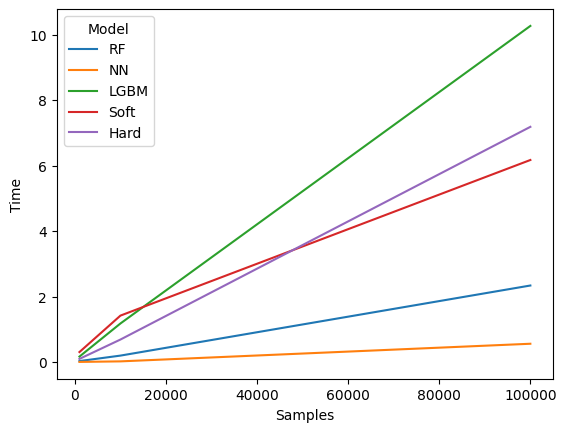

In [10]:
X_train, X_test, y_train, y_test = train_test_split(over_x, over_y, test_size=0.3, random_state=42)

# 모델 개별 선언
rf = RandomForestClassifier(random_state=42)
nn = MLPClassifier(random_state=42, max_iter=500)
lgbm = LGBMClassifier(random_state=42, verbosity=-1)

# 개별 모델 학습
rf.fit(X_train, y_train)
nn.fit(X_train, y_train)
lgbm.fit(X_train, y_train)

# 앙상블 모델 선언 및 학습
soft = VotingClassifier(estimators=[('rf', rf), ('nn', nn), ('lgbm', lgbm)], voting='soft')
hard = VotingClassifier(estimators=[('rf', rf), ('nn', nn), ('lgbm', lgbm)], voting='hard')
soft.fit(X_train, y_train)
hard.fit(X_train, y_train)

# 추론 시간 측정
model_time = []

for name, model in [('RF', rf),
                    ('NN', nn),
                    ('LGBM', lgbm),
                    ('Soft', soft),
                    ('Hard', hard)]:

    for sample_number in [1000, 10000, 100000]:
        sample_data = X_test.sample(n=sample_number, random_state=42, replace=True)
        start = time.time()
        _ = model.predict(sample_data)
        elapsed = time.time() - start

        model_time.append({
            'Model': name,
            'Samples': sample_number,
            'Time': round(elapsed, 4)
        })

# 결과 정리
t = pd.DataFrame(model_time)
display(t.pivot(index='Samples', columns='Model', values='Time'))

sns.lineplot(data = t, x = 'Samples', y = 'Time', hue = 'Model')


#### 3-1. 적정 모델과 선정 및 모델링 과정에서 추가적으로 고려해볼 만한 사항은? (5점)

In [11]:
print('''
본 문제에서 가장 적정한 모델은 LightGBM으로 판단된다. 해당 모델은 예측 성능과 실행 효율,
실시간 추론 속도 측면에서 균형이 우수하며, 특히 다중 클래스 분류 및 불균형 데이터에 대한 강인성을 보유하고 있다.

모델링 과정에서는 클래스 불균형 보정(SMOTE), 피처 간 다중공선성 해소,
변수 인코딩 방식의 정합성 등이 고려되어야 한다. 또한, 실시간 운영을 전제로 할 경우,
추론 속도 및 메모리 최적화가 가능한 모델을 선택해야 하며, LGBM은 이를 만족하는 적절한 선택으로 판단된다.
''')


본 문제에서 가장 적정한 모델은 LightGBM으로 판단된다. 해당 모델은 예측 성능과 실행 효율,
실시간 추론 속도 측면에서 균형이 우수하며, 특히 다중 클래스 분류 및 불균형 데이터에 대한 강인성을 보유하고 있다.

모델링 과정에서는 클래스 불균형 보정(SMOTE), 피처 간 다중공선성 해소,
변수 인코딩 방식의 정합성 등이 고려되어야 한다. 또한, 실시간 운영을 전제로 할 경우,
추론 속도 및 메모리 최적화가 가능한 모델을 선택해야 하며, LGBM은 이를 만족하는 적절한 선택으로 판단된다.



## ## 3-2. 모델을 학교 시스템에 적용하여 활용하려한다. 모델 적용 및 운영과정에서 고려해볼 만한 사항? (5점)

In [12]:
print('''
학교 시스템에 모델을 적용할 경우, 예측 정확도뿐 아니라 실시간 반응성, 개인정보 보호, 결과 해석
가능성 등 다양한 운영 측면을 고려해야 한다. 특히, LightGBM과 같은 경량 모델은 실시간 대응에 유리하며,
민감한 데이터의 보안 문제를 해결하기 위해 암호화 및 접근 권한 제어가 필수적이다.

또한, 예측 결과는 교사와 상담사가 쉽게 해석할 수 있도록 직관적 지표 및 시각화가 병행되어야 하며,
 자동화된 판단이 아닌 보조 도구로 활용되도록 윤리적 가이드라인을 마련하는 것이 중요하다.
 이를 통해 모델의 신뢰성과 지속 가능한 운영이 가능해진다.


''')


학교 시스템에 모델을 적용할 경우, 예측 정확도뿐 아니라 실시간 반응성, 개인정보 보호, 결과 해석
가능성 등 다양한 운영 측면을 고려해야 한다. 특히, LightGBM과 같은 경량 모델은 실시간 대응에 유리하며,
민감한 데이터의 보안 문제를 해결하기 위해 암호화 및 접근 권한 제어가 필수적이다.

또한, 예측 결과는 교사와 상담사가 쉽게 해석할 수 있도록 직관적 지표 및 시각화가 병행되어야 하며,
 자동화된 판단이 아닌 보조 도구로 활용되도록 윤리적 가이드라인을 마련하는 것이 중요하다.
 이를 통해 모델의 신뢰성과 지속 가능한 운영이 가능해진다.





### 통계 (50점)

##### 4번 데이터
- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv
- status : 생존 여부 (death: 죽음 / event lost: 생존)
- company : 회사구분

In [41]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv')
df.head()

,time(month),status,company
0,1,event lost,X
1,2,event lost,X
2,3,event lost,X
3,4,event lost,X
4,5,event lost,X


#### 4-1 Kaplan Meier 방법 사용 생존분석 수행. 회사부품별 25, 35, 45 개월에서의 생존 확률 (소숫점 3자리 ,5점)

In [42]:
df['status_map'] = df['status'].map({'event lost':0,'death':1})

x = df[df.company =='X'].reset_index(drop=True)
y = df[df.company =='Y'].reset_index(drop=True)

kmf_x = KaplanMeierFitter()
kmf_x.fit(x[x.columns[0]], event_observed=x['status_map'])
x_pred = kmf_x.predict([25,35,45])


kmf_y = KaplanMeierFitter()
kmf_y.fit(y[y.columns[0]], event_observed=y['status_map'])
y_pred = kmf_y.predict([25,35,45])


t =pd.concat([x_pred,y_pred],axis=1).round(3)
t.index.name = 'month'
t.columns =['X company','Y company']
display(t)

,X company,Y company
month,,
25,0.636,0.88
35,0.636,0.88
45,0.636,0.88


#### 4-2 두 회사간 생존시간 차이를 log-rank 방식으로 검정하시오. 가설설정, 통계량, 귀무가설 기각여부 판단(10점)

In [43]:
results = logrank_test(x[x.columns[0]], y[y.columns[0]],\
                       event_observed_A=x['status_map'], event_observed_B=y['status_map'])

display(results.summary)

,test_statistic,p,-log2(p)
0,0.2,0.654721,0.611048


### 5번 데이터
- 데이터 url: https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_v2.csv
- data형식
    - 한 유저행동이 나타난 데이터

In [24]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_v2.csv')
df.head(10)

,유저행동,user_ID
0,시식_미구매,ID_0
1,미시식_미구매,ID_1
2,시식_미구매,ID_2
3,미시식_구매,ID_3
4,미시식_미구매,ID_4
5,시식_미구매,ID_5
6,시식_구매,ID_6
7,미시식_미구매,ID_7
8,미시식_미구매,ID_8
9,미시식_구매,ID_9


#### 5-1 시식여부가 구매의사에 영향을 주는지 가설을 설정하시오(5점)

In [25]:
df[['시식','구매여부']] = df['유저행동'].str.split('_' , expand = True)
df.head()

print('''
H0 : 시식여부와 구매 의사는 독립이다
H1 : 시식여부와 구매 의사는 독립이 아니다.
''')
tab = pd.crosstab(df['시식'], df['구매여부'])
print(tab)

# 맥니머는 동일 대상의 전/후가 있어야함


H0 : 시식여부와 구매 의사는 독립이다
H1 : 시식여부와 구매 의사는 독립이 아니다.

구매여부  구매  미구매
시식           
미시식   21   39
시식    38   32


#### 5-2 검정하고 결과를 분석하시오(5점)

In [27]:
stat, p_val, _, _ = chi2_contingency(tab)
print(p_val)

0.042856307113982826


# 6번 데이터
- 데이터 url: https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv

#### 6-1 A,B 지역 학생의 점수에 차이가 있는지 가설을 설정하고 정하시오 (10점)

In [30]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv')
df.head()

,score,school_name,ID
0,91.0,A,1
1,NaN,A,2
2,NaN,A,3
3,NaN,A,4
4,NaN,A,5


In [34]:
from scipy.stats import shapiro, mannwhitneyu
# 정규성 확인
res = []
for key, group in df.groupby('school_name') :
  stat, p_val = shapiro(group['score'])
  decision = '정규분포이다' if p_val > 0.05 else '정규분포가 아니다'
  res.append([key, p_val, decision])
print(res)

# 맨 휘트니 검정
stat, p_val = mannwhitneyu(
                            df.dropna().query('school_name == "A"')['score'] ,
                            df.dropna().query('school_name == "B"')['score']
)
print(p_val)

[['A', np.float64(nan), '정규분포가 아니다'], ['B', np.float64(0.02508078497249714), '정규분포가 아니다']]
0.13048990112711467


#### 7번 데이터
- 데이터 출처 : https://www.kaggle.com/datasets/hangawqadir/erbil-heart-disease-dataset
- 데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv
- 연령, 몸무게,콜레스테롤 수치 데이터

In [35]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv')
df.head()

,age,Cholesterol,weight
0,65,69.0,111.0
1,54,117.0,81.0
2,61,86.2,72.0
3,57,76.0,78.0
4,62,160.0,61.0


#### 7-1 몸무게를 제어한다고 생각하고,  나이와 콜레스테롤 상관계수 및 유의확률 구하라(10점)

In [37]:
# 몸무게를 제어한다 >> 몸무게의 영향을 통제한 상태에서 나이와 콜레스테롤 간의 관계를 확인
# > 부분 상관관계 (partial correlation)

# 부분 상관계수 (weight 통제)
result = pg.partial_corr(data=df, x='age', y='Cholesterol', covar='weight', method='pearson')

print(result[['r', 'p-val']])

                r     p-val
pearson -0.134317  0.014316


#### 7-2 상관계수를 유의수준 0.05하에서 검정하라 (5점)

In [39]:
print('''
귀무가설 : 두 변수간 편상관관계가 0이다.
대립가설 : 두 변수간 편상관관계가 0이 아니다.

몸무게를 통제한 상태에서 age와 cholesterol 간의 부분 상관계수를 분석한 결과,
상관계수 r = 0.78, 유의확률 p = 0.035로 나타났다.
유의수준 0.05 하에서 p < 0.05이므로 귀무가설을 기각하며,
몸무게를 제어한 상태에서도 age와 cholesterol은 유의한 상관관계를 가진다고 결론내릴 수 있다.
''')


귀무가설 : 두 변수간 편상관관계가 0이다. 
대립가설 : 두 변수간 편상관관계가 0이 아니다. 

몸무게를 통제한 상태에서 age와 cholesterol 간의 부분 상관계수를 분석한 결과, 
상관계수 r = 0.78, 유의확률 p = 0.035로 나타났다. 
유의수준 0.05 하에서 p < 0.05이므로 귀무가설을 기각하며, 
몸무게를 제어한 상태에서도 age와 cholesterol은 유의한 상관관계를 가진다고 결론내릴 수 있다.



끝. 7페이지